In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import sklearn

In [2]:
data = pd.read_csv('health_data.csv')
data.head()

,age,restbps,chol,category
0,26,109,243,0
1,27,106,156,0
2,28,107,225,0
3,27,105,277,0
4,30,96,221,0


In [3]:
X = data.to_numpy()[:, :3]
Y = data.to_numpy()[:, 3]
split = 0.8 #using 70:30 split, random each time
train_samples = np.random.choice(X.shape[0], int(split*X.shape[0]))
test_samples = np.array([i for i in range(X.shape[0]) if i not in list(train_samples)])

X_train = X[[train_samples]]
Y_train = Y[[train_samples]]

X_test = X[[test_samples]]
Y_test = Y[[test_samples]]

X_0 = X_train[Y_train == 0]
X_1 = X_train[Y_train == 1]

X_test_0 = X_test[Y_test == 0]
X_test_1 = X_test[Y_test==1]
print(X_test.shape)

(303, 3)


E:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys
E:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
E:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  

In [4]:
X_00 = data[data['category'] == 0].to_numpy()[:, :3]
X_11 = data[data['category'] == 1].to_numpy()[:, :3]

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


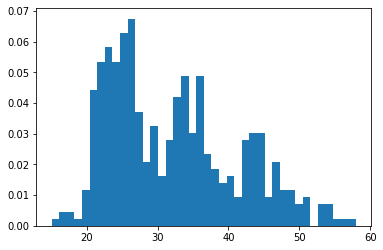

In [5]:
hist1 = plt.hist(X_00[:, 0], bins=40, normed=True)

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


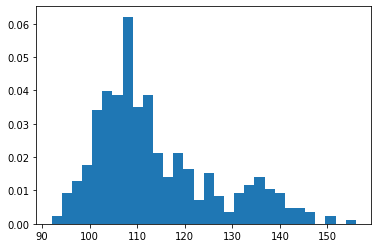

In [6]:
hist2 = plt.hist(X_00[:, 1], bins=30, normed=True)

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


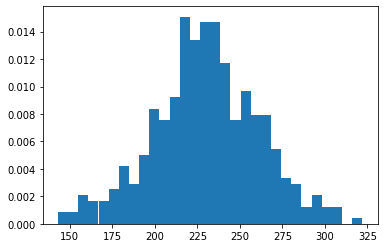

In [7]:
hist3 = plt.hist(X_00[:, 2], bins=30, normed=True)

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


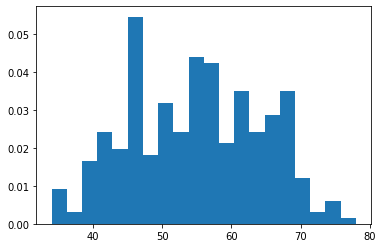

In [8]:
hist11 = plt.hist(X_11[:, 0], bins=20, normed=True)

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


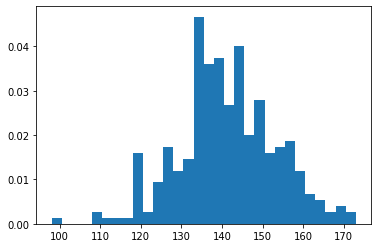

In [9]:
hist12 = plt.hist(X_11[:, 1], bins=30, normed=True)

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


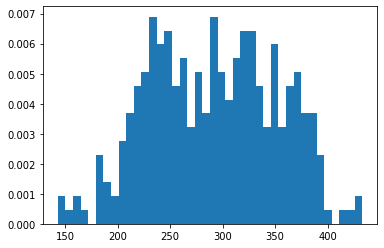

In [10]:
hist13 = plt.hist(X_11[:, 2], bins=40, normed=True)

In [11]:
#Hypercube_Kernel
def hypercube_kernel(h, x, x_i):
    assert (x.shape == x_i.shape)
    return (x - x_i) / (h)


#Window_function   
def parzen_window_func(x_vec):
    for row in x_vec:
        if np.abs(row) > (1/2):
            return 0
        return 1

#Estimation
def parzen_estimation_for_hyper_cube(x_samples, point_x, h, d):
    dimensions = x_samples.shape[1]
    assert (len(point_x) == dimensions)
    k_n = 0
    for row in x_samples:
        x_i = hypercube_kernel(h=h, x=point_x, x_i=row)
        k_n += parzen_window_func(x_i)
    return (k_n / len(x_samples)) / (h**d)

In [12]:
def pdf_multivariate_gauss(x, mu, cov):
    assert(mu.shape[0] > mu.shape[1])
    assert(x.shape[0] > x.shape[1])
    assert(cov.shape[0] == cov.shape[1])
    assert(mu.shape[0] == cov.shape[0])
    assert(mu.shape[0] == x.shape[0])
    part1 = 1 / ( ((2* np.pi)**(len(mu)/2)) * (np.linalg.det(cov)**(1/2)) )
    part2 = (-1/2) * ((x-mu).T.dot(np.linalg.inv(cov))).dot((x-mu))
    return float(part1 * np.exp(part2))

In [35]:
#Gaussian_kernel_and_window_function
def gaussian_window_function(cov, x, x_i):
    assert (x.shape == x_i.shape)
    assert(cov.shape[0] == cov.shape[1])
    assert(x_i.shape[0] == cov.shape[0])
    return pdf_multivariate_gauss(x, x_i,cov)


#Estimation
def parzen_estimation_for_gaussian(x_samples, point_x, cov):
    point_x = point_x.reshape((3,1))
    prob = 0.0
    for row in x_samples:
        row = row.reshape((3,1))
        prob += gaussian_window_function(cov,point_x,row)
    return prob 

In [33]:
#prior calculation
P = [float(len(X_0))/ float(len(X_0) + len(X_1)) ,float(len(X_1))/ float(len(X_0) + len(X_1)) ]
P

[0.5642857142857143, 0.4357142857142857]

# Hyper_Cube

In [45]:
#calculation of posterior
def posterior(X_train_0,X_train_1, data, P,h,d):
    prob = np.zeros(2, dtype = np.float64)
    class_probabilities = [parzen_estimation_for_hyper_cube(X_train_0, data, h, d), parzen_estimation_for_hyper_cube(X_train_1, data, h, d)]
    
    #print(probabilities)
    for i in range(2):
        prob[i] = class_probabilities[i]*P[i]
    return prob

In [46]:
def prediction(data, X_train_0, X_train_1,P, h, Th):
    Probabilities = posterior(X_train_0, X_train_1, data, P, h, X_train.shape[1])
    Probabilities = Probabilities/sum(Probabilities)
    #print(Probabilities)
    if Probabilities[1] > Th:
        return 1
    else:
        return 0

In [47]:
#computing accuracy on test data.
C = np.zeros((2,2)) #[[]]
for i in range((X_test_0.shape[0])):
    y_pred = prediction(X_test_0[i], X_0,X_1, P, 1, 0.5)
    C[y_pred, 0] += 1
for i in range((X_test_1.shape[0])):
    y_pred = prediction(X_test_1[i], X_0, X_1, P, 1, 0.5)
    C[y_pred, 1] += 1

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [48]:
C

array([[156.,  33.],
       [ 22.,  92.]])

In [49]:
acc = (C[0,0] + C[1,1])/np.sum(C)
print(acc)

0.8184818481848185


In [50]:
precision = (C[1,1])/(C[1,0] + C[1,1])
precision

0.8070175438596491

In [51]:
Recall = (C[1,1])/(C[0,1] + C[1,1])
Recall

0.736

In [52]:
from tqdm import tqdm
Precision = []
Recall = []
ACC = []
F1_score = []
kk = range(1,300)
for h in tqdm(np.linspace(0.01,10,100)):
    C = np.zeros((2,2)) #[[]]
    for i in range((X_test_0.shape[0])):
        y_pred = prediction(X_test_0[i], X_0,X_1, P, h, 0.5)
        C[y_pred, 0] += 1
    for i in range((X_test_1.shape[0])):
        y_pred = prediction(X_test_1[i], X_0, X_1, P, h, 0.5)
        C[y_pred, 1] += 1
    acc = (C[0,0] + C[1,1])/np.sum(C) 
    pr = C[1,1]/(C[1,1] + C[1,0])
    rec = C[1,1]/(C[1,1] + C[0,1])
    f1 = 2*(pr*rec)/(pr + rec)
    Precision.append(pr)
    Recall.append(rec)
    F1_score.append(f1)
    ACC.append(acc)
#plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC curve');

  0%|          | 0/100 [00:00<?, ?it/s]E:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


In [53]:
kk = np.linspace(0.01,10,100)

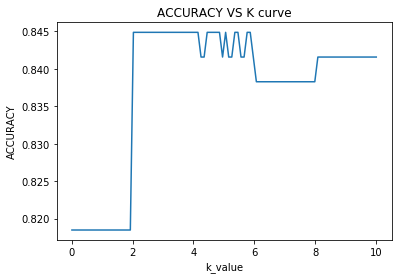

In [54]:
plt.plot(kk ,ACC, '-')
plt.xlabel('k_value'); plt.ylabel('ACCURACY'); plt.title('ACCURACY VS K curve');

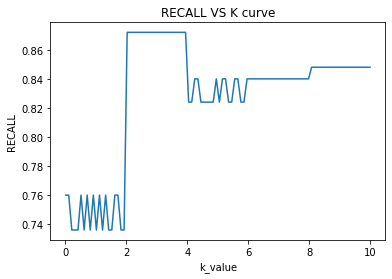

In [55]:
plt.plot(kk, Recall, '-')
plt.xlabel('k_value'); plt.ylabel('RECALL'); plt.title('RECALL VS K curve');

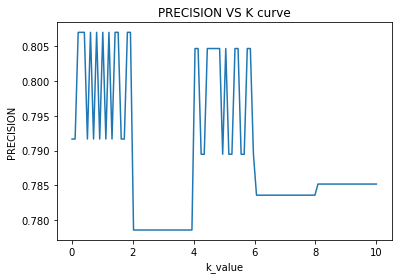

In [56]:
plt.plot(kk, Precision, '-')
plt.xlabel('k_value'); plt.ylabel('PRECISION'); plt.title('PRECISION VS K curve');

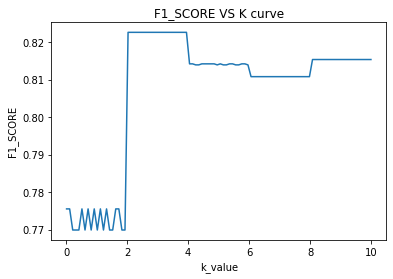

In [57]:
plt.plot(kk, F1_score, '-')
plt.xlabel('k_value'); plt.ylabel('F1_SCORE'); plt.title('F1_SCORE VS K curve');

# Gaussian Window function

In [29]:
#calculation of posterior
def posterior(X_train_0,X_train_1, data, P,cov):
    prob = np.zeros(2, dtype = np.float64)
    class_probabilities = [parzen_estimation_for_gaussian(X_train_0, data,cov ), parzen_estimation_for_gaussian(X_train_1, data,cov)]
    
    #print(probabilities)
    for i in range(2):
        prob[i] = class_probabilities[i]*P[i]
    return prob

In [30]:
def prediction(data, X_train_0, X_train_1,P, cov, Th):
    Probabilities = posterior(X_train_0, X_train_1, data, P, cov)
    Probabilities = Probabilities/sum(Probabilities)
    #print(Probabilities)
    if Probabilities[1] > Th:
        return 1
    else:
        return 0

In [36]:
#computing accuracy on test data.
C = np.zeros((2,2)) #[[]]
cov = np.eye(X_train.shape[1],dtype = np.float)
for i in range((X_test_0.shape[0])):
    y_pred = prediction(X_test_0[i], X_0,X_1, P, cov, 0.5)
    C[y_pred, 0] += 1
for i in range((X_test_1.shape[0])):
    y_pred = prediction(X_test_1[i], X_0, X_1, P, cov, 0.5)
    C[y_pred, 1] += 1

In [37]:
C

array([[141.,  40.],
       [ 37.,  85.]])

In [39]:
from tqdm import tqdm
Precision = []
Recall = []
ACC = []
F1_score = []
kk = range(1,300)
for h in tqdm(np.linspace(0.01,10,100)):
    C = np.zeros((2,2)) #[[]]
    cov = np.eye(X_train.shape[1],dtype = np.float)
    for i in range((X_test_0.shape[0])):
        y_pred = prediction(X_test_0[i], X_0,X_1, P, cov*h, 0.5)
        C[y_pred, 0] += 1
    for i in range((X_test_1.shape[0])):
        y_pred = prediction(X_test_1[i], X_0, X_1, P, cov*h, 0.5)
        C[y_pred, 1] += 1
    acc = (C[0,0] + C[1,1])/np.sum(C) 
    pr = C[1,1]/(C[1,1] + C[1,0])
    rec = C[1,1]/(C[1,1] + C[0,1])
    f1 = 2*(pr*rec)/(pr + rec)
    Precision.append(pr)
    Recall.append(rec)
    F1_score.append(f1)
    ACC.append(acc)

  0%|          | 0/100 [00:00<?, ?it/s]E:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 100/100 [08:02<00:00,  4.82s/it]


In [38]:
cov = np.eye(X_train.shape[1],dtype = np.float)*2
cov

array([[2., 0., 0.],
       [0., 2., 0.],
       [0., 0., 2.]])

In [40]:
kk = np.linspace(0.01,10,100)

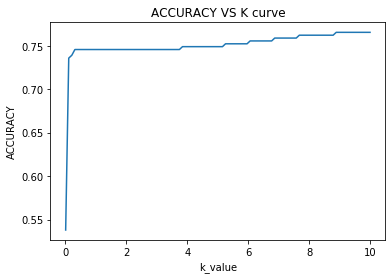

In [41]:
plt.plot(kk ,ACC, '-')
plt.xlabel('k_value'); plt.ylabel('ACCURACY'); plt.title('ACCURACY VS K curve');

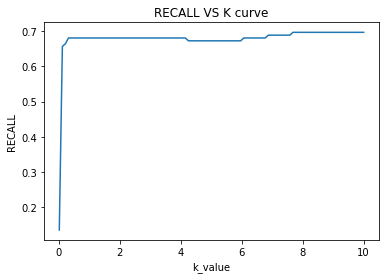

In [42]:
plt.plot(kk, Recall, '-')
plt.xlabel('k_value'); plt.ylabel('RECALL'); plt.title('RECALL VS K curve');

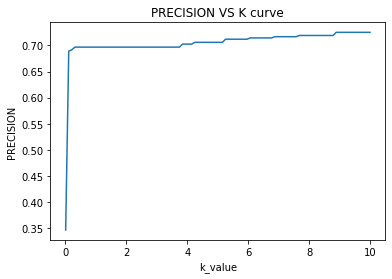

In [43]:
plt.plot(kk, Precision, '-')
plt.xlabel('k_value'); plt.ylabel('PRECISION'); plt.title('PRECISION VS K curve');

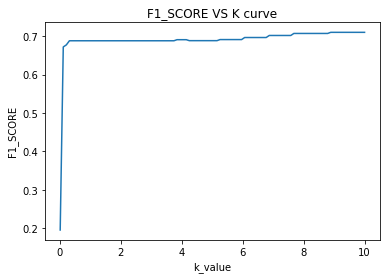

In [44]:
plt.plot(kk, F1_score, '-')
plt.xlabel('k_value'); plt.ylabel('F1_SCORE'); plt.title('F1_SCORE VS K curve');